# Trip Itinerary Planning

**Author:** Faizul Islam<br>
**Course:** ISE571: Heuristic Search Methods, Term: 242<br>
**Instructor:** Dr. Alaa Khamis<br>
**Department:** Department of Industrial & Systems Engineering, King Fahd University of Petroleum and Minerals

## Introduction

The Trip Itinerary Problem (TIP) consists of a problem where a list of locations to visit must be selected, and have routes formulated between them, such that some sort of cost function (such as number of visited places, POI ranking, traveller satisfaction, etc) is maximized. <br>

Essentially, the problem can be broken down into the following:

1. Select a subset from a set of POIs (or candidate points).
2. Construct one or more routes between a home point (like a hotel, etc.) and those points, in order to satisfy time and distance constraints.


# Import Libraries

In [221]:
!pip install openpyxl
import pandas as pd
import numpy as np
import requests
import random
import os
import json
import time
import matplotlib.pyplot as plt
import math
import getpass
from io import BytesIO 
from sklearn.ensemble import RandomForestClassifier

## Dataset

This implementation uses three datasets of POIs of three KSA cities: Jeddah, Abha, and Al Khobar from mapping APIs such as Google Maps API.

Jeddah has 87 POIs (including 'Millennium Al Masar Jeddah' as home), Abha has 81 POIs (including 'EWAA EXPRESS HOTEL' as home), and Al Khobar has 29 POIs (including 'Hilton Al Khobar King Fahd Causeway' as home).

Additionally, a precomputed matrix of distances between POIs was created in order eliminate the need for real-time distance queries and speed up the algorithm running times. For this purpose Mapbox API was utilized.

## Problem Formulation

### Variables

$V_i$ : poi i<br>
$R_i$ : rating of $V_i$<br>
$C_{ij}$ : the time it takes for the user to travel from $V_i$ to $V_j$<br>
$L_{ij}$ : the distance between $V_i$ and $V_j$<br>
$O_i,E_i$ : the openning/closing time of $V_i$<br>
$D_i$ : duration visitor want to spend on $V_i$<br>
$S_i$ : the time when the visitor arrives $V_i$<br>
$a_{ijk}$ : whether $V_j$ is visited after $V_i$ in tour $k$. True -> 1, False -> 0<br>
$b_{ij}$ : whether $V_i$ is visited in tour $j$. True -> 1, False -> 0<br>
$m$ : the number of tours a visitor wants to take<br>
$\gamma$ : weight of soft constraint<br>
$ T_{start}, T_{end}$ : start and end time of the tour<br>
$Q$ : a large positive constant used for integer programming modelling

### Objective

$\sum_{i=0}^{m} \sum_{j=1}^{n} R_i b_{ij} - \sum_{i=1}^{n} \sum_{j=1}^{n}  \sum_{k=1}^{m} \gamma L_{ij} a_{ijk}$

### Constraints

$\sum_{i=0}^{m} \sum_{j=1}^{n} a_{1ij} = \sum_{i=0}^{m} \sum_{j=1}^{n} a_{nij} = m$ (m tours are start from V1
and end with Vn)

$\sum_{i=2}^{n-1} \sum_{j=1}^{m} b_{ij} \le 1$ (all vertices
are visited only once)

$\sum_{i=1}^{n-1} a_{ijk} = b_{kj}, k=2,...,n-1; j=1,...,m$ (all tours are connected, used together with the constraint below)

$\sum_{i=2}^{n} a_{ijk} = b_{kj}, k=2,...,n-1; j=1,...,m$ (all tours are connected, used together with the constraint above)

$S_{ik} + D_{i} + C_{ij} - S_{jk} \le Q(1-a_{ijk}), \> i=1,...,n-1;j = 2,... n; k = 1,...,m$ (travel time is continuous)

$O_{i} \le S_{ij} + D_{i} \le E_{i}, \> i = 1,...,n; j = 1,...,m$ (vertices are visited within the time window)


# Load Data and Generate Distance Matrix

In [222]:
# Load the dataset
"""
For Jeddah use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/jeddah_tourist_attractions.xlsx'
For Abha use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/abha_tourist_attractions.xlsx'
For Al Khobar use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/al_khobar_tourist_attractions.xlsx'
"""
file_path = 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/al_khobar_tourist_attractions.xlsx'
response = requests.get(file_path)
df = pd.read_excel(BytesIO(response.content), engine='openpyxl')
#df = pd.read_excel(file_path) 

# Pre-clean the openings column
df['openings'] = df['openings'].fillna('0000,2359')  # Fill missing with full day
df['openings'] = df['openings'].astype(str).str.replace('[^0-9,]', '', regex=True)  # Clean unwanted chars

# Prepare list of coordinates
locations = df[['lng', 'lat']].values.tolist()  # Mapbox uses [lng, lat]

# Generate distance and duration matrices with Mapbox API
"""
For Jeddah use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/jeddah_distance_matrix.json'
For Abha use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/abha_distance_matrix.json'
For Al Khobar use: 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/al_khobar_distance_matrix.json'
"""

DISTANCE_MATRIX_FILE = 'https://raw.githubusercontent.com/Faizul314/Tourist-Trip-Itinerary-Planning/main/al_khobar_distance_matrix.json' 

def get_distance_duration_matrix(locations):
    """
    Generate distance and duration matrices using the Mapbox Directions API.
    First tries to load from the GitHub JSON file; if unavailable or incomplete, fetches from API.
    """
    n = len(locations)

    # ✅ Step 1: Try to load from GitHub JSON file
    try:
        response = requests.get(DISTANCE_MATRIX_FILE)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        data = response.json()
        
        if "distance_matrix" in data and "duration_matrix" in data:
            print("✅ Loaded distance matrix from GitHub JSON file.")
            return np.array(data["distance_matrix"]), np.array(data["duration_matrix"])
        else:
            print("⚠️ GitHub JSON file exists but is incomplete. Recomputing matrix.")
    except (requests.RequestException, json.JSONDecodeError) as e:
        print(f"⚠️ Could not load from GitHub: {str(e)}. Recomputing matrix.")

    # ✅ Step 2: Request API key only when needed
    MAPBOX_ACCESS_TOKEN = getpass.getpass("Enter your Mapbox API Key: ")

    # ✅ Step 3: Compute distance & duration matrices from API
    distance_matrix = np.zeros((n, n))
    duration_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
                duration_matrix[i][j] = 0
            else:
                coords = f"{locations[i][0]},{locations[i][1]};{locations[j][0]},{locations[j][1]}"
                url = f"https://api.mapbox.com/directions/v5/mapbox/driving/{coords}?access_token={MAPBOX_ACCESS_TOKEN}&geometries=geojson"
                
                response = requests.get(url).json()
                
                if 'routes' in response and len(response['routes']) > 0:
                    route = response['routes'][0]
                    distance_matrix[i][j] = route['distance'] / 1000  # Convert meters to km
                    duration_matrix[i][j] = route['duration'] / 60  # Convert seconds to minutes
                else:
                    distance_matrix[i][j] = np.inf
                    duration_matrix[i][j] = np.inf

                time.sleep(0.1)  # ✅ Prevent hitting API rate limits

    # Note: Removed the local file saving since we're using GitHub
    print("✅ Distance matrix computation complete (not saved to GitHub).")

    return distance_matrix, duration_matrix
    
# Generate matrices
distance_matrix, duration_matrix = get_distance_duration_matrix(locations)

✅ Loaded distance matrix from GitHub JSON file.


# Problem Formulation

In [223]:
# Constants
TIME_BUDGET = 480  # 8 hours in minutes
STAY_DURATION = 60  # 1 hour at each POI
GAMMA = 1e-5  # Soft constraint parameter
Q = 10000  # Slack variable for continuous travel time

# --------------------------
# Supporting Functionality: Convert HHMM to minutes
# --------------------------
def convert_hhmm_to_minutes(hhmm):
    clean_time = ''.join(filter(str.isdigit, hhmm))
    if clean_time == '':
        return 0  
    hours = int(clean_time) // 100
    minutes = int(clean_time) % 100
    return hours * 60 + minutes

# -------------------------------------
# 1) Objective Function (total rating - travel penalties)
# -------------------------------------
def calculate_objective(tours, df, distance_matrix, gamma=GAMMA):
    total_rating = 0
    total_distance = 0
    for tour in tours:
        total_rating += sum(df.iloc[i]['rating'] for i in tour if df.iloc[i]['category'] != 'Home')
        total_distance += sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))
    return total_rating - gamma * total_distance

# -------------------------------------
# 2) Each Trip Starts and Ends at (Home)
# 3) No POI is Visited More Than Once
# -------------------------------------
def generate_initial_solution(df, m, duration_matrix):
    # Identify POIs (excluding Home)
    poi_indices = [i for i in range(len(df)) if df.iloc[i]['category'] != 'Home']
    home_idx = df[df['category'] == 'Home'].index[0]
    random.shuffle(poi_indices)  # Randomize order of POIs

    tours = [[] for _ in range(m)]

    # Assign POIs to tours while satisfying constraints
    for poi in poi_indices:
        for idx in range(m):
            temp_tour = [home_idx] + tours[idx] + [poi, home_idx]
            if is_tour_feasible(temp_tour, df, duration_matrix):
                tours[idx].append(poi)  # Ensure POI is assigned to only one tour
                break

    # Add Home at start and end of each tour to satisfy Constraint 2
    final_tours = [[home_idx] + tour + [home_idx] for tour in tours]
    return final_tours

# -------------------------------------
# 4) Tour Connectivity (sequencing between POIs)
# 5) Continuous Travel Time
# 6) Visiting Hours Must Be Respected
# -------------------------------------
def is_tour_feasible(tour, df, duration_matrix):
    time = 0
    home_idx = df[df['category'] == 'Home'].index[0]

    for i in range(len(tour)-1):
        current_poi = df.iloc[tour[i]]
        next_poi = df.iloc[tour[i+1]]

        # Travel time C_ij between POIs
        travel_time = duration_matrix[tour[i]][tour[i+1]]
        time += travel_time

        # Visiting window constraint (O_i, E_i)
        openings_str = next_poi.get('openings', '0000,2359')
        openings_split = openings_str.split(',')
        opening_time, closing_time = (0, 1439) if len(openings_split) != 2 else map(convert_hhmm_to_minutes, openings_split)

        arrival_time = time
        if arrival_time < opening_time:  # wait until opening time if early
            arrival_time = opening_time
        if arrival_time > closing_time:  # invalid if after closing
            return False

        # Stay duration Di added (if not Home)
        if next_poi['category'] != 'Home':
            time = arrival_time + STAY_DURATION

        # Ensure trip ends within overall time window Tstart → Tend
        return_to_home_time = time + duration_matrix[tour[i+1]][home_idx]
        if return_to_home_time > TIME_BUDGET:
            return False

    return True

# Solution Approach (Simulated Annealing)

In [224]:
# Generate Neighbor (Swap within a tour)
def generate_neighbor(tours, m):
    new_tours = [tour[:] for tour in tours]

    if m == 1:
        # Single tour case
        tour = new_tours[0]
        if len(tour) <= 3:
            return new_tours  # Nothing to change

        if len(tour) > 4 and random.random() < 0.5:
            # Reverse a sub-path
            i, j = sorted(random.sample(range(1, len(tour) - 1), 2))
            tour[i:j] = list(reversed(tour[i:j]))
        else:
            # Swap two POIs (excluding Home at start/end)
            i, j = random.sample(range(1, len(tour) - 1), 2)
            tour[i], tour[j] = tour[j], tour[i]

    else:
        # Multi-tour case
        tour_idx = random.randint(0, m - 1)
        tour = new_tours[tour_idx]

        op_type = random.choice(['swap', 'insert'])

        if op_type == 'swap' and len(tour) > 3:
            i, j = random.sample(range(1, len(tour) - 1), 2)
            tour[i], tour[j] = tour[j], tour[i]

        elif op_type == 'insert' and m > 1:
            from_idx, to_idx = random.sample(range(m), 2)
            from_tour = new_tours[from_idx]
            to_tour = new_tours[to_idx]

            if len(from_tour) > 3:
                poi_idx = random.choice(range(1, len(from_tour) - 1))
                poi = from_tour.pop(poi_idx)
                insert_pos = random.randint(1, len(to_tour) - 1)
                to_tour.insert(insert_pos, poi)

    return new_tours

# Simulated Annealing Algorithm with Correct Convergence Tracking
def simulated_annealing(df, distance_matrix, duration_matrix, m=1, initial_temp=1000, cooling_rate=0.995, max_iter=1000, best_known=0):
    tours = generate_initial_solution(df, m, duration_matrix)
    best_tours = tours[:]
    
    current_obj = calculate_objective(tours, df, distance_matrix)
    best_obj = current_obj
    
    temp = initial_temp
    obj_progress = [current_obj]
    
    start_time = time.time()
    convergence_iter = 0

    for iteration in range(max_iter):
        new_tours = generate_neighbor(tours, m)  
        
        if not all(is_tour_feasible(tour, df, duration_matrix) for tour in new_tours):
            continue
        
        new_obj = calculate_objective(new_tours, df, distance_matrix)
        delta = new_obj - current_obj
        
        if delta > 0 or random.uniform(0, 1) < np.exp(delta / temp):
            tours = new_tours
            current_obj = new_obj
            
            if new_obj > best_obj:
                best_tours = new_tours
                best_obj = new_obj
                convergence_iter = iteration
        
        obj_progress.append(best_obj)
        temp *= cooling_rate
        
        if temp < 1e-3:
            break
    
    total_time = time.time() - start_time
    gap_bk = ((best_known - best_obj) / best_known) * 100 if best_known != 0 else None
    
    return best_tours, best_obj, total_time, m, convergence_iter, gap_bk, obj_progress


# Solution Approach (Adaptive Simulated Annealing)

In [225]:
# ---------------------------------------------
# Adaptive Neighbor Operator (swap, insert, reverse)
# ---------------------------------------------
def generate_adaptive_neighbor(tours, iteration, strategy_cycle=100):
    new_tours = [tour[:] for tour in tours]
    strategy = iteration % strategy_cycle

    if strategy < strategy_cycle // 4:
        # Swap within one tour
        tour_idx = random.randint(0, len(new_tours) - 1)
        tour = new_tours[tour_idx]
        if len(tour) > 3:
            i, j = random.sample(range(1, len(tour) - 1), 2)
            tour[i], tour[j] = tour[j], tour[i]

    elif strategy < strategy_cycle // 2 and len(new_tours) > 1:
        # Insert POI from one tour to another
        from_idx, to_idx = random.sample(range(len(new_tours)), 2)
        from_tour = new_tours[from_idx]
        to_tour = new_tours[to_idx]
        if len(from_tour) > 3:
            poi_idx = random.choice(range(1, len(from_tour) - 1))
            poi = from_tour.pop(poi_idx)
            insert_pos = random.randint(1, len(to_tour) - 1)
            to_tour.insert(insert_pos, poi)

    elif strategy < 3 * strategy_cycle // 4:
        # Reverse subpath
        tour_idx = random.randint(0, len(new_tours) - 1)
        tour = new_tours[tour_idx]
        if len(tour) > 4:
            i, j = sorted(random.sample(range(1, len(tour) - 1), 2))
            tour[i:j] = list(reversed(tour[i:j]))

    else:
        # Block shift: move 2 adjacent POIs forward/back
        tour_idx = random.randint(0, len(new_tours) - 1)
        tour = new_tours[tour_idx]
        if len(tour) > 5:
            i = random.randint(1, len(tour) - 3)
            block = tour[i:i+2]
            del tour[i:i+2]
            insert_pos = random.randint(1, len(tour) - 1)
            tour[insert_pos:insert_pos] = block

    return new_tours

# ---------------------------------------------
# Adaptive Simulated Annealing Algorithm
# ---------------------------------------------
def adaptive_simulated_annealing(df, distance_matrix, duration_matrix, m=1, 
                                 initial_temp=1000, max_iter=1000, best_known=0,
                                 stagnation_limit=100, reheating_factor=1.5):
    current_solution = generate_initial_solution(df, m, duration_matrix)
    best_solution = current_solution[:]
    current_obj = calculate_objective(current_solution, df, distance_matrix)
    best_obj = current_obj

    temp = initial_temp
    stagnation_counter = 0
    obj_progress = [current_obj]
    convergence_iter = 0

    start_time = time.time()

    for iteration in range(max_iter):
        new_solution = generate_adaptive_neighbor(current_solution, iteration)

        if not all(is_tour_feasible(tour, df, duration_matrix) for tour in new_solution):
            continue

        new_obj = calculate_objective(new_solution, df, distance_matrix)
        delta = new_obj - current_obj
        accept = False

        if delta > 0:
            accept = True
        else:
            prob = np.exp(delta / temp)
            if random.uniform(0, 1) < prob:
                accept = True

        if accept:
            current_solution = new_solution
            current_obj = new_obj
            if new_obj > best_obj:
                best_solution = new_solution
                best_obj = new_obj
                convergence_iter = iteration
                stagnation_counter = 0
            else:
                stagnation_counter += 1
        else:
            stagnation_counter += 1

        if stagnation_counter >= stagnation_limit:
            temp *= reheating_factor
            stagnation_counter = 0

        temp *= 0.995 if delta > 0 else 0.99
        obj_progress.append(best_obj)

        if temp < 1e-3:
            break

    total_time = time.time() - start_time
    gap_bk = ((best_known - best_obj) / best_known) * 100 if best_known != 0 else None

    return best_solution, best_obj, total_time, m, convergence_iter, gap_bk, obj_progress

# Train ML Model

In [226]:
def train_poi_selector(df, tours):
    """
    Train a binary classifier to predict which POIs are likely to be included in a good tour.
    """
    df = df.copy()
    df['visited'] = 0
    for tour in tours:
        for idx in tour:
            df.at[idx, 'visited'] = 1

    # Feature engineering
    df['open_duration'] = df['openings'].apply(
        lambda o: convert_hhmm_to_minutes(o.split(',')[1]) - convert_hhmm_to_minutes(o.split(',')[0]) 
        if isinstance(o, str) and ',' in o else 1440
    )

    features = df[['rating', 'lat', 'lng', 'open_duration']]
    labels = df['visited']

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(features, labels)
    return model

# ML-Guided Initial Solution

In [227]:
def predict_poi_scores(df, model, add_noise=True, noise_std=0.05):
    df = df.copy()
    df['open_duration'] = df['openings'].apply(
        lambda o: convert_hhmm_to_minutes(o.split(',')[1]) - convert_hhmm_to_minutes(o.split(',')[0]) 
        if isinstance(o, str) and ',' in o else 1440
    )
    features = df[['rating', 'lat', 'lng', 'open_duration']]
    df['ml_score'] = model.predict_proba(features)[:, 1]

    if add_noise:
        df['ml_score'] += np.random.normal(0, noise_std, size=len(df))
        df['ml_score'] = df['ml_score'].clip(0, 1)  # keep in valid range

    return df
    
def generate_ml_guided_initial_solution(df, m, duration_matrix, model):
    df = predict_poi_scores(df, model, add_noise=True)  # now uses noise by default
    poi_indices = [i for i in df.sort_values('ml_score', ascending=False).index if df.iloc[i]['category'] != 'Home']
    home_idx = df[df['category'] == 'Home'].index[0]

    tours = [[] for _ in range(m)]

    for poi in poi_indices:
        for idx in range(m):
            temp_tour = [home_idx] + tours[idx] + [poi, home_idx]
            if is_tour_feasible(temp_tour, df, duration_matrix):
                tours[idx].append(poi)
                break

    return [[home_idx] + tour + [home_idx] for tour in tours]

# Solution Approach (Hybrid ML + Simulated Annealing)

In [228]:
# ML-Guided SA Solver
def ml_guided_simulated_annealing(df, distance_matrix, duration_matrix, model, m=1, 
                                  initial_temp=1000, cooling_rate=0.995, max_iter=1000, best_known=0):
    tours = generate_ml_guided_initial_solution(df, m, duration_matrix, model)
    best_tours = tours[:]
    current_obj = calculate_objective(tours, df, distance_matrix)
    best_obj = current_obj

    temp = initial_temp
    obj_progress = [current_obj]
    convergence_iter = 0
    start_time = time.time()

    for iteration in range(max_iter):
        new_tours = generate_adaptive_neighbor(tours, iteration)  # reuse adaptive neighbor
        if not all(is_tour_feasible(tour, df, duration_matrix) for tour in new_tours):
            continue

        new_obj = calculate_objective(new_tours, df, distance_matrix)
        delta = new_obj - current_obj

        if delta > 0 or random.uniform(0, 1) < np.exp(delta / temp):
            tours = new_tours
            current_obj = new_obj
            if new_obj > best_obj:
                best_tours = new_tours
                best_obj = new_obj
                convergence_iter = iteration

        obj_progress.append(best_obj)
        temp *= cooling_rate
        if temp < 1e-3:
            break

    total_time = time.time() - start_time
    gap_bk = ((best_known - best_obj) / best_known) * 100 if best_known != 0 else None

    return best_tours, best_obj, total_time, m, convergence_iter, gap_bk, obj_progress

# Solution Approach (Hybrid ML + Adaptive Simulated Annealing)

In [229]:
def ml_guided_adaptive_simulated_annealing(df, distance_matrix, duration_matrix, model, m=1, 
                                           initial_temp=1000, max_iter=1000, best_known=0,
                                           stagnation_limit=100, reheating_factor=1.5):
    # ML-guided initial solution
    tours = generate_ml_guided_initial_solution(df, m, duration_matrix, model)
    best_tours = tours[:]
    current_obj = calculate_objective(tours, df, distance_matrix)
    best_obj = current_obj

    temp = initial_temp
    stagnation_counter = 0
    obj_progress = [current_obj]
    convergence_iter = 0

    start_time = time.time()

    for iteration in range(max_iter):
        new_tours = generate_adaptive_neighbor(tours, iteration)

        if not all(is_tour_feasible(tour, df, duration_matrix) for tour in new_tours):
            continue

        new_obj = calculate_objective(new_tours, df, distance_matrix)
        delta = new_obj - current_obj
        accept = False

        if delta > 0:
            accept = True
        else:
            prob = np.exp(delta / temp)
            if random.uniform(0, 1) < prob:
                accept = True

        if accept:
            tours = new_tours
            current_obj = new_obj
            if new_obj > best_obj:
                best_tours = new_tours
                best_obj = new_obj
                convergence_iter = iteration
                stagnation_counter = 0
            else:
                stagnation_counter += 1
        else:
            stagnation_counter += 1

        if stagnation_counter >= stagnation_limit:
            temp *= reheating_factor
            stagnation_counter = 0

        temp *= 0.995 if delta > 0 else 0.99
        obj_progress.append(best_obj)

        if temp < 1e-3:
            break

    total_time = time.time() - start_time
    gap_bk = ((best_known - best_obj) / best_known) * 100 if best_known != 0 else None

    return best_tours, best_obj, total_time, m, convergence_iter, gap_bk, obj_progress

# Run Solver and Plot Results


Running Simulated Annealing for 1 Tours:
Best Objective Value: 27.30
Execution Time: 4.16 seconds
Number of Tours: 1
Converged at Iteration: 786
Gap from Best Known Solution: 22.00%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - I love KSA (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - Corniche Park Fountain (Tourist Attraction)
 - Al Mana Roundabout (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


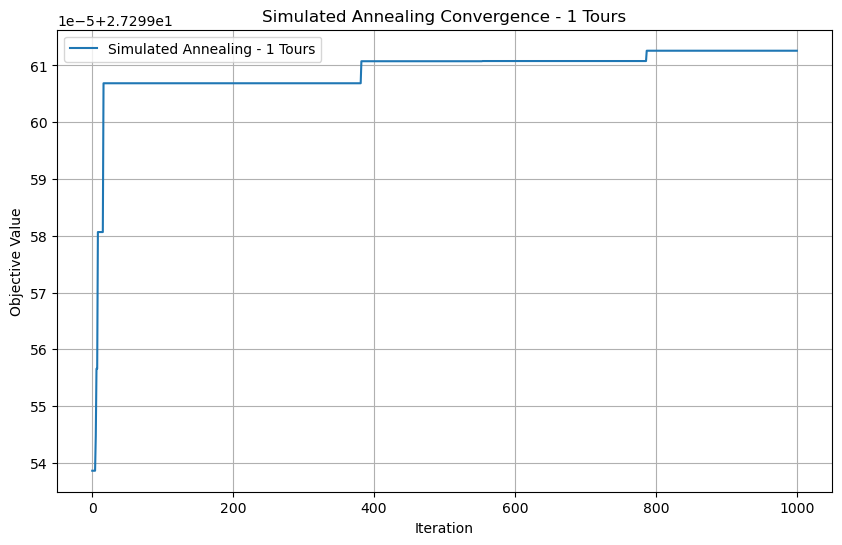


Running Simulated Annealing for 2 Tours:
Best Objective Value: 53.00
Execution Time: 5.84 seconds
Number of Tours: 2
Converged at Iteration: 269
Gap from Best Known Solution: 24.29%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dome Festival (Tourist Attraction)
 - Toy train start point (Tourist Attraction)
 - Duck Lake (Tourist Attraction)
 - HNO & MNO (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - Walpouf session (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - ub (Tourist Attraction)
 - Khobar Water Tower (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - Corniche Park Fountain (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Shubaili Beach (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


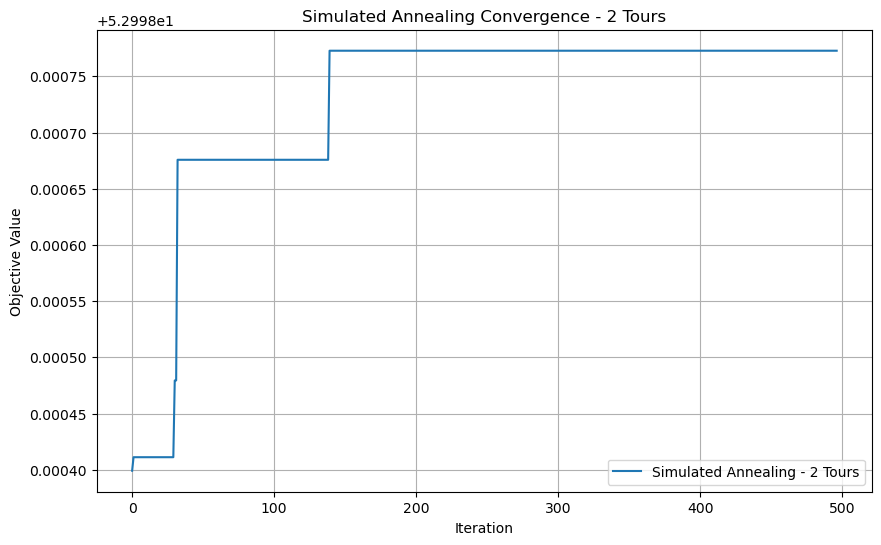


Running Simulated Annealing for 4 Tours:
Best Objective Value: 106.30
Execution Time: 10.65 seconds
Number of Tours: 4
Converged at Iteration: 243
Gap from Best Known Solution: 24.07%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - Boating (Tourist Attraction)
 - I Love Khobar (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Al -Khobar Nights Gallery (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - The University Lake (Tourist Attraction)
 - Dome Festival (Tourist Attraction)
 - Walpouf session (Tourist Attraction)
 - Duck Lake (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - Obayyah Roundabout (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 3:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Khobar corniche (Tourist Attraction)

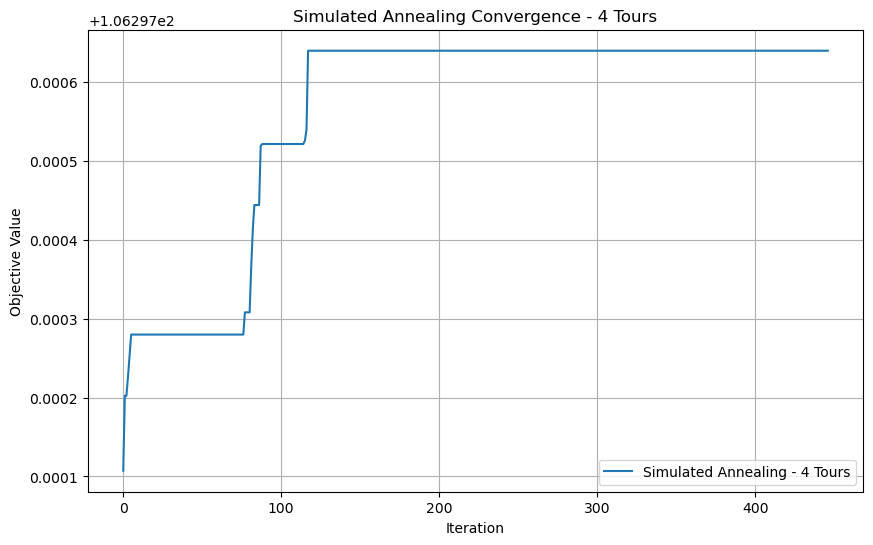


Running Adaptive SA for 1 Tours:
Best Objective Value: 25.40
Execution Time: 3.88 seconds
Number of Tours: 1
Converged at Iteration: 578
Gap from Best Known Solution: 27.43%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dome Festival (Tourist Attraction)
 - Khobar Water Tower (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - Obayyah Roundabout (Tourist Attraction)
 - Shubaili Beach (Tourist Attraction)
 - Walpouf session (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


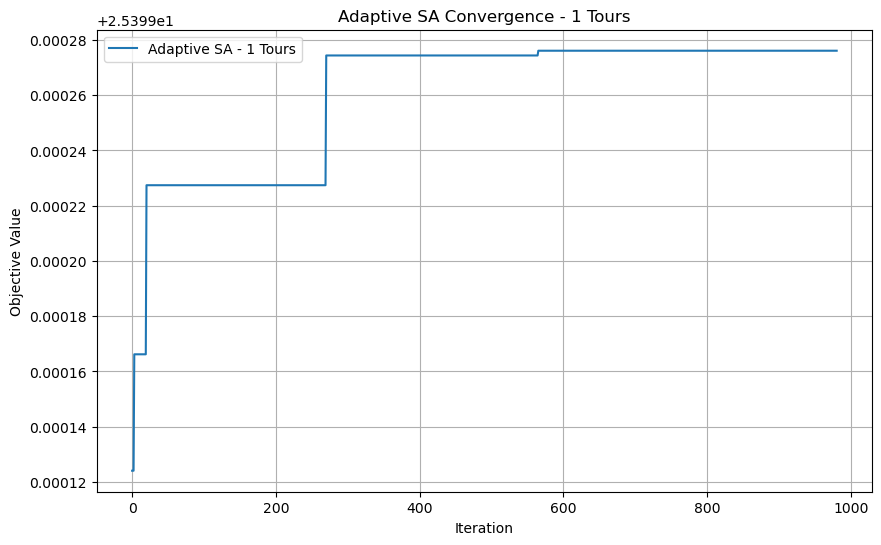


Running Adaptive SA for 2 Tours:
Best Objective Value: 53.10
Execution Time: 6.62 seconds
Number of Tours: 2
Converged at Iteration: 605
Gap from Best Known Solution: 24.14%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Khobar Water Tower (Tourist Attraction)
 - Al Mana Roundabout (Tourist Attraction)
 - Boating (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Toy train start point (Tourist Attraction)
 - HNO & MNO (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - North Khobar New Beach (Tourist Attraction)
 - The University Lake (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - I Love Khobar (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


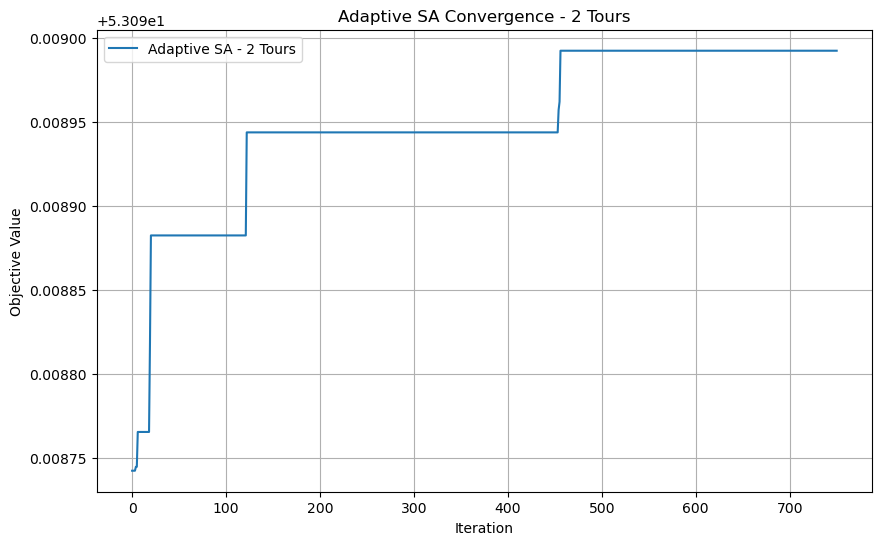


Running Adaptive SA for 4 Tours:
Best Objective Value: 105.20
Execution Time: 12.69 seconds
Number of Tours: 4
Converged at Iteration: 790
Gap from Best Known Solution: 24.86%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - The University Lake (Tourist Attraction)
 - Walpouf session (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Toy train start point (Tourist Attraction)
 - Duck Lake (Tourist Attraction)
 - Al -Khobar Nights Gallery (Tourist Attraction)
 - Khobar Water Tower (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Unification Square (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 3:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Boating (Tourist At

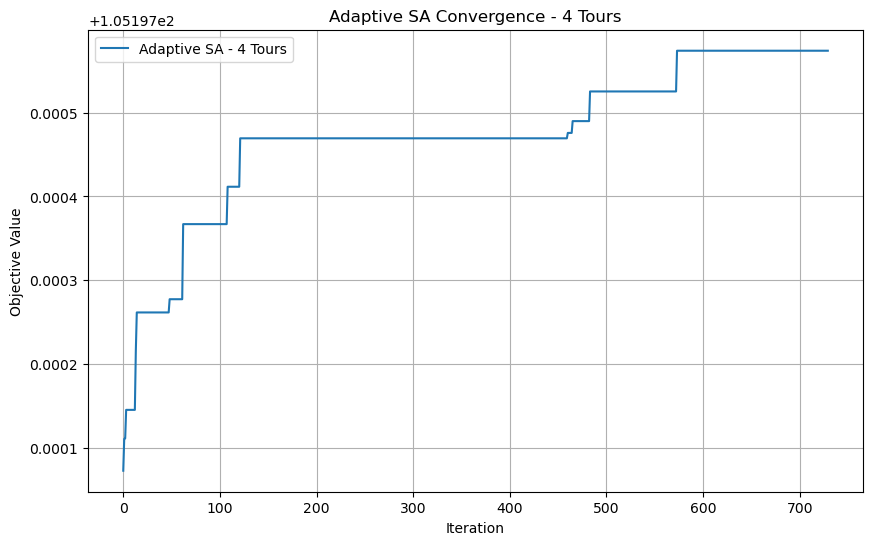


Running Hybrid ML + SA for 1 Tours:
Best Objective Value: 27.60
Execution Time: 3.86 seconds
Number of Tours: 1
Converged at Iteration: 966
Gap from Best Known Solution: 21.14%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - ub (Tourist Attraction)
 - Dome Festival (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


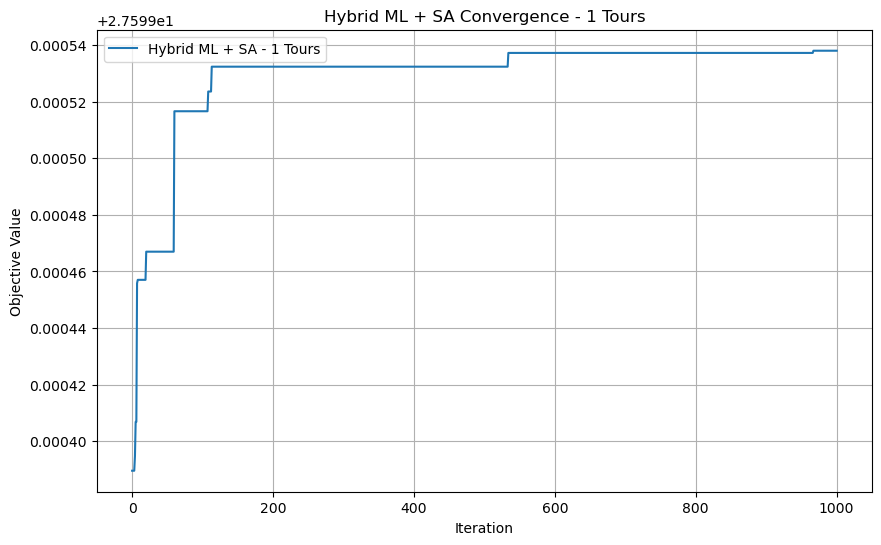


Running Hybrid ML + SA for 2 Tours:
Best Objective Value: 55.50
Execution Time: 6.47 seconds
Number of Tours: 2
Converged at Iteration: 372
Gap from Best Known Solution: 20.72%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - ub (Tourist Attraction)
 - Dome Festival (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - The University Lake (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - North Khobar New Beach (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


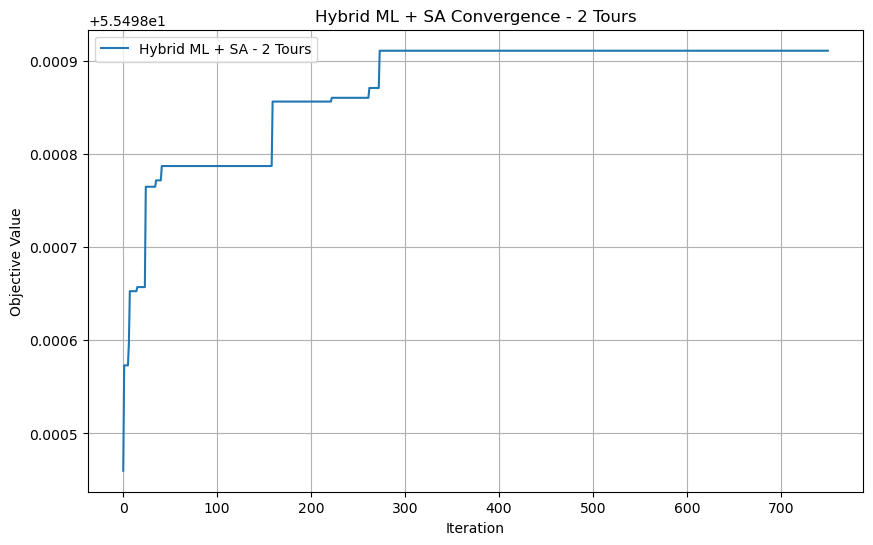


Running Hybrid ML + SA for 4 Tours:
Best Objective Value: 106.10
Execution Time: 12.86 seconds
Number of Tours: 4
Converged at Iteration: 857
Gap from Best Known Solution: 24.22%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dome Festival (Tourist Attraction)
 - Al Mana Roundabout (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - ub (Tourist Attraction)
 - Dugheither Leisure Island (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - North Khobar New Beach (Tourist Attraction)
 - Al -Shatil Island (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 3:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - I Love Khobar (Tourist Attraction)
 - 

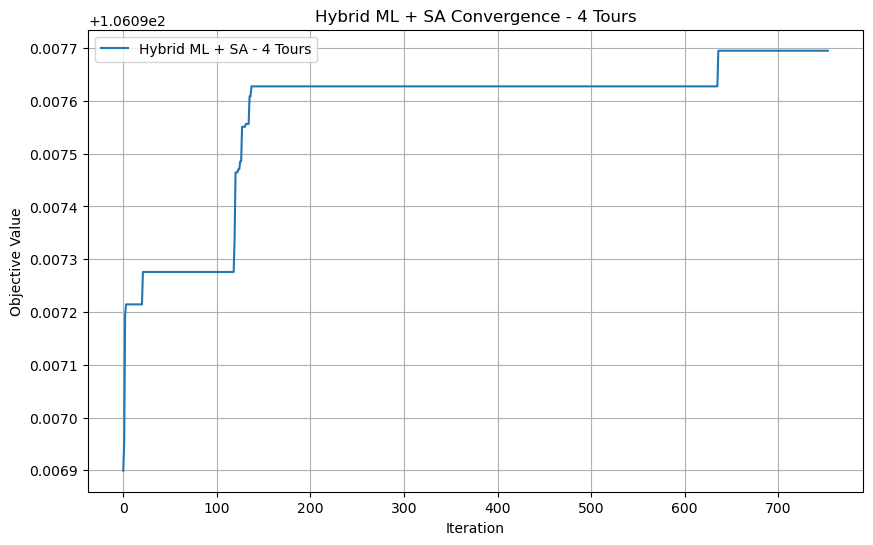


Running Hybrid ML + ASA for 1 Tours:
Best Objective Value: 27.40
Execution Time: 3.90 seconds
Number of Tours: 1
Converged at Iteration: 264
Gap from Best Known Solution: 21.72%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - ub (Tourist Attraction)
 - Dome Festival (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


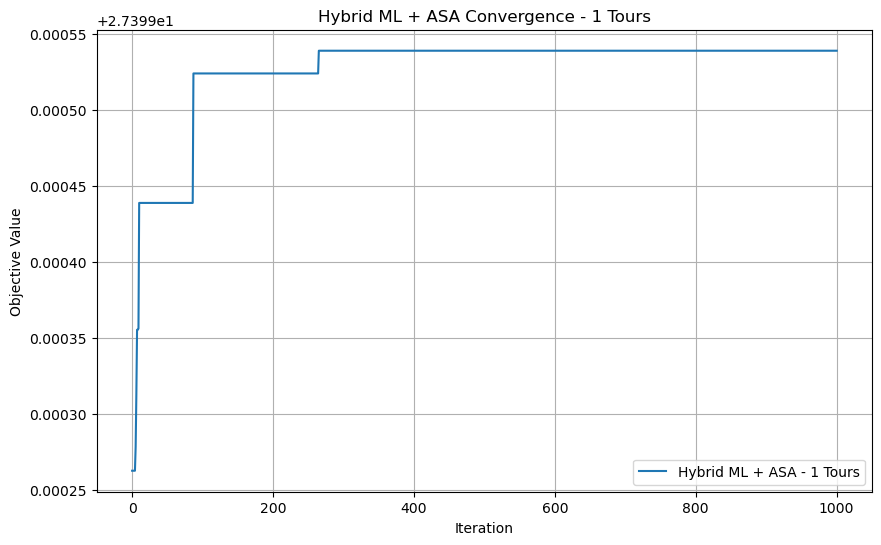


Running Hybrid ML + ASA for 2 Tours:
Best Objective Value: 55.50
Execution Time: 6.62 seconds
Number of Tours: 2
Converged at Iteration: 256
Gap from Best Known Solution: 20.72%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dome Festival (Tourist Attraction)
 - ub (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - North Khobar New Beach (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - The University Lake (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)


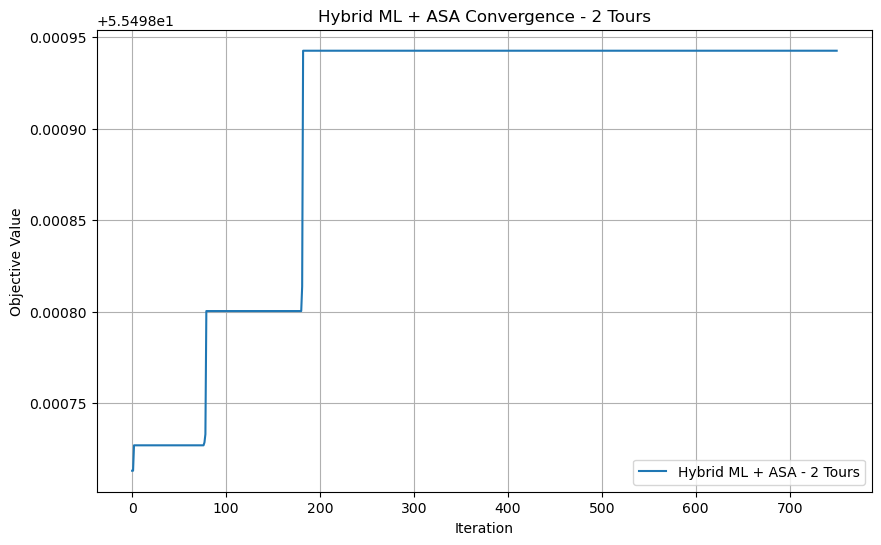


Running Hybrid ML + ASA for 4 Tours:
Best Objective Value: 106.90
Execution Time: 12.72 seconds
Number of Tours: 4
Converged at Iteration: 514
Gap from Best Known Solution: 23.64%
Tour 1:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dome Festival (Tourist Attraction)
 - Rasil Square | Rasel Square (Tourist Attraction)
 - Albenayyan Roundabout (Tourist Attraction)
 - I love KSA (Tourist Attraction)
 - ub (Tourist Attraction)
 - Candles Plaza (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 2:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - Dugheither Leisure Island (Tourist Attraction)
 - HNO & MNO (Tourist Attraction)
 - Khobar Corniche Artificial Lake (Tourist Attraction)
 - Khobar corniche (Tourist Attraction)
 - The roundabout of the news (Tourist Attraction)
 - North Khobar New Beach (Tourist Attraction)
 - Hilton Al Khobar King Fahd Causeway (Home)
Tour 3:
 - Hilton Al Khobar King Fahd Causeway (Home)
 - The University Lake (Tourist Attraction)
 - Toy 

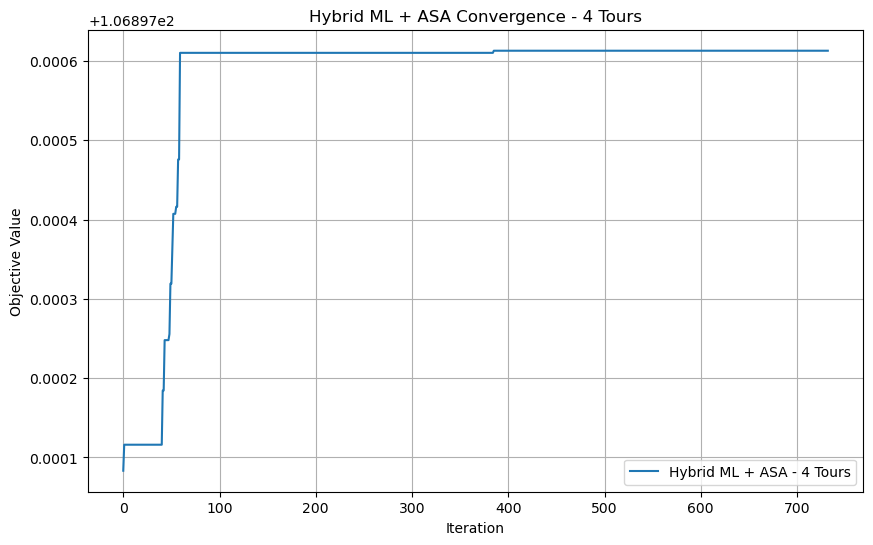


--- Grouped Summary of All Methods by Number of Tours ---


,Algorithm,Tours,Objective,Time (s),Iteration,Gap (%)
0,Simulated Annealing,1,27.299613,4.163332,786,22.001107
1,Adaptive SA,1,25.399276,3.884677,578,27.430640
2,Hybrid ML + SA,1,27.599538,3.859306,966,21.144177
3,Hybrid ML + ASA,1,27.399539,3.896092,264,21.715603
4,Simulated Annealing,2,52.998773,5.838722,269,24.287467
5,Adaptive SA,2,53.098992,6.616884,605,24.144297
6,Hybrid ML + SA,2,55.498911,6.466571,372,20.715841
7,Hybrid ML + ASA,2,55.498943,6.618417,256,20.715796
8,Simulated Annealing,4,106.297640,10.651767,243,24.073114
9,Adaptive SA,4,105.197574,12.694212,790,24.858876


In [230]:
# Define known BEST_KNOWN per tour
BEST_KNOWN_PER_TOUR = 35  # known optimal value for m=1
BEST_KNOWN = BEST_KNOWN_PER_TOUR * 1  # for training with m=1

# Run SA and ASA to gather good training tours
sa_best_tours, _, _, _, _, _, _ = simulated_annealing(
    df, distance_matrix, duration_matrix, m=1, max_iter=1000, best_known=BEST_KNOWN)

asa_best_tours, _, _, _, _, _, _ = adaptive_simulated_annealing(
    df, distance_matrix, duration_matrix, m=1, max_iter=1000, best_known=BEST_KNOWN)

# Combine SA and ASA tours for training
combined_tours = sa_best_tours + asa_best_tours
ml_model = train_poi_selector(df, combined_tours)

# Store results for summary
comparison_results = []

# Define all methods in a dictionary
methods = {
    'Simulated Annealing': simulated_annealing,
    'Adaptive SA': adaptive_simulated_annealing,
    'Hybrid ML + SA': lambda df, dm, durm, m, **kwargs: ml_guided_simulated_annealing(df, dm, durm, model=ml_model, m=m, **kwargs),
    'Hybrid ML + ASA': lambda df, dm, durm, m, **kwargs: ml_guided_adaptive_simulated_annealing(df, dm, durm, model=ml_model, m=m, **kwargs)
}

# Run each method for 1, 2, and 4 tours
for name, method in methods.items():
    for m in [1, 2, 4]:
        BEST_KNOWN = BEST_KNOWN_PER_TOUR * m  # scale linearly with m
        print(f"\nRunning {name} for {m} Tours:")
        best_tours, best_obj, total_time, num_tours, convergence_iter, gap_bk, obj_progress = method(
            df, distance_matrix, duration_matrix, m=m, max_iter=1000, best_known=BEST_KNOWN)

        # Print summary
        print(f"Best Objective Value: {best_obj:.2f}")
        print(f"Execution Time: {total_time:.2f} seconds")
        print(f"Number of Tours: {num_tours}")
        print(f"Converged at Iteration: {convergence_iter}")
        if gap_bk is not None:
            print(f"Gap from Best Known Solution: {gap_bk:.2f}%")
        else:
            print("Best Known Solution not provided.")
        
        # Print Optimal Itineraries
        for idx, tour in enumerate(best_tours):
            print(f"Tour {idx+1}:")
            for poi_idx in tour:
                print(f" - {df.iloc[poi_idx]['name']} ({df.iloc[poi_idx]['category']})")

        # Record result
        comparison_results.append({
            'Algorithm': name,
            'Tours': m,
            'Objective': best_obj,
            'Time (s)': total_time,
            'Iteration': convergence_iter,
            'Gap (%)': gap_bk
        })

        # Plot convergence
        plt.figure(figsize=(10,6))
        plt.plot(obj_progress, label=f'{name} - {m} Tours')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.title(f'{name} Convergence - {m} Tours')
        plt.legend()
        plt.grid(True)
        plt.show()

# Create DataFrame
results_df = pd.DataFrame(comparison_results)

# Define custom sort order for Algorithm
algorithm_order = ['Simulated Annealing', 'Adaptive SA', 'Hybrid ML + SA', 'Hybrid ML + ASA']

# Convert Algorithm column to categorical with the custom order
results_df['Algorithm'] = pd.Categorical(results_df['Algorithm'], categories=algorithm_order, ordered=True)

# Sort by Tours, then custom Algorithm order
results_df = results_df.sort_values(by=['Tours', 'Algorithm']).reset_index(drop=True)

# Optional: reorder columns
results_df = results_df[['Algorithm', 'Tours', 'Objective', 'Time (s)', 'Iteration', 'Gap (%)']]

# Display summary
print("\n--- Grouped Summary of All Methods by Number of Tours ---")
display(results_df)